In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import sys
import time
import seaborn as sns
import pandas as pd

sys.path.append('/home/atekawade/TomoEncoders/scratchpad/voids_paper/configs/')
from tomo_encoders import Grid
from tomo_encoders.misc import viewer
from tomo_encoders import DataFile
import cupy as cp
from tomo_encoders.reconstruction.project import get_projections
from tomo_encoders.reconstruction.recon import recon_binning, recon_patches_3d, recon_patches_3d_2
from tomo_encoders.misc.voxel_processing import cylindrical_mask, normalize_volume_gpu
from params import model_path, get_model_params
from tomo_encoders.neural_nets.surface_segmenter import SurfaceSegmenter
import tensorflow as tf
from cupyx.scipy.ndimage import zoom

######## START GPU SETTINGS ############
########## SET MEMORY GROWTH to True ############
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass        
######### END GPU SETTINGS ############

model_tag = "M_a07"
model_names = {"segmenter" : "segmenter_Unet_%s"%model_tag}
model_params = get_model_params(model_tag)
# patch size
wd = 32
# guess surface parameters
b = 4
b_K = 4



 ####################################################### 


Model is M_a07
n_filters [8, 16]
n_blocks 2
activation lrelu
batch_norm True
isconcat [True, True]
pool_size [2, 4]


In [2]:
def guess_surface(projs, theta, center, fe, b, b_K, wd):
    ## P-GUESS ##
    # reconstruction
    V_bin = recon_binning(projs, theta, center, b_K, b)    
    # segmentation
    min_max = V_bin.min(), V_bin.max()
    p3d_bin = Grid(V_bin.shape, width = wd)
    x = p3d_bin.extract(V_bin) # effectively 128^3 patches in a full volume
    x = fe.predict_patches("segmenter", x[...,np.newaxis], 256, None, min_max = min_max)[...,0]
    p3d_bin.fill_patches_in_volume(x, V_bin)

    # find patches on surface
    p3d = Grid(V_bin.shape, width = int(wd//b))
    x = p3d.extract(V_bin)

    return x, p3d


In [39]:

# initialize segmenter fCNN
fe = SurfaceSegmenter(model_initialization = 'load-model', \
                     model_names = model_names, \
                     model_path = model_path)    
fe.test_speeds(128,n_reps = 5, input_size = (wd,wd,wd))    

# read data and initialize output arrays
## to-do: ensure reconstructed object has dimensions that are a multiple of the (wd,wd,wd) !!    
hf = h5py.File('/data02/MyArchive/aisteer_3Dencoders/tmp_data/projs_2k.hdf5', 'r')
projs = np.asarray(hf["data"][:])
theta = np.asarray(hf['theta'][:])
center = float(np.asarray(hf["center"]))
hf.close()

# make sure projection shapes are divisible by the patch width (both binning and full steps)
print(f'SHAPE OF PROJECTION DATA: {projs.shape}')

##### BEGIN ALGORITHM ########
# guess surface
print("STEP: guess surface")
start_guess = cp.cuda.Event(); end_guess = cp.cuda.Event(); start_guess.record()
# p_surf, p_ones, p_zeros = guess_surface(projs, theta, center, fe, b, b_K, wd)
x, p = guess_surface(projs, theta, center, fe, b, b_K, wd)
end_guess.record(); end_guess.synchronize(); t_guess = cp.cuda.get_elapsed_time(start_guess,end_guess)
print(f'TIME: guessing neighborhood of surface: {t_guess/1000.0:.2f} seconds')


inf. time per patch (32, 32, 32) = 2.56 ms, nb = 128
inf. time per voxel 78.10 ns


inf. time per patch (32, 32, 32) = 1.29 ms, nb = 128
inf. time per voxel 39.33 ns


inf. time per patch (32, 32, 32) = 1.21 ms, nb = 128
inf. time per voxel 36.79 ns


inf. time per patch (32, 32, 32) = 1.17 ms, nb = 128
inf. time per voxel 35.80 ns


inf. time per patch (32, 32, 32) = 1.21 ms, nb = 128
inf. time per voxel 37.03 ns


SHAPE OF PROJECTION DATA: (1500, 896, 2176)
STEP: guess surface
TIME: guessing neighborhood of surface: 4.70 seconds


In [43]:
pz, py, px = [int(p.vol_shape[i]/p.wd) for i in range(3)]

In [51]:
sums = (np.sum(x, axis = (1,2,3))/(8**3)).astype(np.float16)

In [73]:
vol_p = np.zeros((pz,py,px), dtype = np.float16)

In [77]:
vol_p.flat[:].size
sums.size

129472

In [78]:
idx_surf = np.where((sums>0) & (sums<1))[0]

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

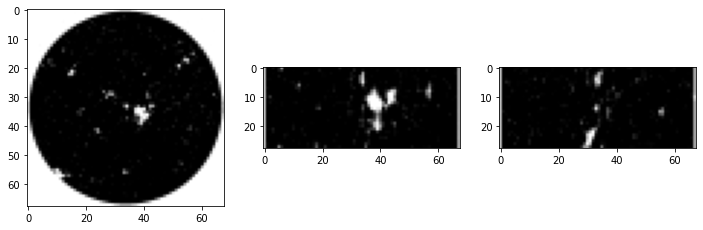

In [65]:
fig, ax = plt.subplots(1,3, figsize = (12,4))
viewer.view_midplanes(vol_p, ax = ax)

TRASH

In [77]:
np.sort(np.unique(idx_perc))

array([    11,     14,     15, ..., 129296, 129302, 129307])